<center><img src="./Images/Portugal.jpg" width="1500" alt="image"></center>
<center>Agricultural area around Quinta da Leda seen by Sentinel-2</center>

# <center> Investigating NDVI prediction with Sentinel 1 data <br><br> Study area: Portugal - 2021/03-2021/11 </center> 
<center>
    Author: Aleksandar Ilic - <a href="mailto:aleksandar.ilic@stud.fh-campuswien.ac.at"> aleksandar.ilic@stud.fh-campuswien.ac.at</a> 
    <br> 
    This work is licensed under a <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/"> Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a></center>
<br>
<br>

<div class="alert alert-block alert-info">
<b>Tip:</b> More information on the characteristics of Sentinel-1 and Sentinel-2 can be found <a href="https://sentinel.esa.int/web/sentinel/missions/"> here </a>
</div>

<font size="5" color="#8b1900"  face="verdana"> <B>1- Load Python packages</B></font>

In [1]:
# MODULE                                                        # DESCRIPTION     
import numpy as np                                              # scientific computing 
import matplotlib as mtp                                        # create visualizations
import matplotlib.pyplot as plt                                 # create visualizations
import pandas as pd                                             # data analysis and manipulation
import geopandas as gpd                                         # extends the datatypes used by pandas to allow spatial operations on geom. types
import snappy                                                   # SNAP python interface
import earthpy.plot as ep                                       # plot and work with spatial raster and vector data using open source tools 
import rasterio                                                 # Rasterio reads and writes raster formats and provides a Python API based 
from rasterio.plot import reshape_as_raster, reshape_as_image   # on Numpy N-dimensional arrays and GeoJSON
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import re
from datetime import datetime
import shapely
from shapely import geometry
from pathlib import Path

# turns on 'nline plotting', where plot graphics will appear in the notebook below the cell that produced them.
%matplotlib inline              

# Change module setting
pd.options.display.max_colwidth = 80       # Longer text in pd.df

<font size="5" color="#8b1900"  face="verdana"> <B>2. Load and visualize input data</B></font>

In [2]:
# Path to preprocessed and co-located Sentinel-1, Sentinel-2, Landsat 7 and Landsat 8 stack
NDVI_SAR_MSI_msk = './Data/NDVI_SAR_MSI_sub.tif'

# Loads the input dataset into a dataset object
src = rasterio.open(NDVI_SAR_MSI_msk)

# Getting list of band names, uses snappy package 
prep_vis = snappy.ProductIO.readProduct(NDVI_SAR_MSI_msk)
bands = list(prep_vis.getBandNames())

In [3]:
import re
from datetime import datetime, date

collocation_flags = [x for x in prep_vis.getFlagCodingGroup().getNodeNames()]
#display(collocation_flags)
dates = []
for flag in collocation_flags:
    if('S2A' in flag or 'S2B' in flag):
        dates.append(re.search('MSIL2A_(.+?)T11', flag).group(1))
    elif('LE07' in flag or 'LC08' in flag):
        dates.append(re.search('203032_(.+?)_2021', flag).group(1))
    elif('S1A' in flag or 'S1B' in flag):
        dates.append(re.search('1SDV_(.+?)T', flag).group(1))

days_of_year = [datetime.strptime(x, '%Y%m%d').date().timetuple().tm_yday for x in dates]
print(days_of_year)

[74, 84, 94, 124, 134, 194, 224, 234, 284, 79, 139, 149, 159, 179, 189, 199, 209, 229, 259, 259, 269, 269, 279, 299, 82, 146, 162, 194, 210, 74, 90, 106, 186, 202, 218, 234, 282, 298, 77, 78, 83, 89, 90, 95, 101, 102, 107, 113, 114, 119, 125, 126, 131, 137, 138, 143, 149, 150, 161, 162, 173, 174, 179, 185, 186, 191, 197, 198, 203, 209, 210, 215, 222, 227, 233, 234, 239, 245, 246, 251, 257, 258, 263, 269, 270, 275, 281, 282, 287, 293, 294, 299, 305, 77, 83, 84, 89, 95, 96, 101, 107, 108, 113, 119, 120, 131, 132, 143, 144, 155, 156, 161, 167, 168, 179, 180, 191, 192, 197, 203, 204, 215, 216, 221, 227, 228, 233, 239, 240, 245, 251, 252, 257, 263, 264, 269, 275, 276, 281, 287, 288, 293, 299, 300, 305]


<font size="5" color="#8b1900"  face="verdana"> <B>3. Create Training/Validation data</B></font>

In [4]:
training_points_backup = './Points/train_pts.csv'

train_pts = pd.read_csv(training_points_backup)
train_pts = train_pts.drop(["Unnamed: 0"], axis = 1)
train_pts.head()

LONGITUDE   LATITUDE                                      geometry  \
0  -7.058992  40.980445  POINT (-7.058991979348787 40.98044466479965)   
1  -6.974599  41.089108  POINT (-6.974598831367607 41.08910773769045)   
2  -7.000707  41.032570  POINT (-7.000707386952199 41.03256984443507)   
3  -6.962188  41.084143  POINT (-6.962188074311554 41.08414343486803)   
4  -7.067542  40.970608  POINT (-7.067541611987403 40.97060799068855)   

     NDVI_M    NDMI_M   NDVI_S0   NDMI_S0   NDVI_S1   NDMI_S1   NDVI_S2  ...  \
0  0.593819 -0.017954  0.593819 -0.017954  0.603325  0.028441  0.656018  ...   
1  0.789298  0.284397  0.789298  0.284397  0.801072  0.320861  0.847312  ...   
2  0.452821 -0.043098  0.452821 -0.043098  0.386343 -0.073412  0.410883  ...   
3  0.330285  0.017316  0.330285  0.017316  0.282261  0.005138  0.223608  ...   
4  0.618780 -0.020160  0.618780 -0.020160  0.600970  0.031696  0.553903  ...   

   NRPB_S145  Gamma0_VH_S145  Gamma0_VV_S145  localIncidenceAngle_S145  \
0  -0.764794        0.015060        0.056111                 34.490746   
1  -0.788934        0.015930        0.063495                 31.009712   
2  -0.806535        0.014522        0.051636                 35.184242   
3  -0.871491        0.015243        0.095937                 23.364964   
4  -0.798747        0.008726        0.030308                 29.185322   

   projectedLocalIncidenceAngle_S145  NRPB_S146  Gamma0_VH_S146  \
0                          34.309967  -0.325105        0.044363   
1                          30.201559  -0.461556        0.048167   
2                          34.903278  -0.451049        0.082871   
3                          23.195847  -0.439088        0.052537   
4                          29.164215  -0.280822        0.030551   

   Gamma0_VV_S146  localIncidenceAngle_S146  projectedLocalIncidenceAngle_S146  
0        0.206066                 46.689766                          46.416252  
1        0.227247                 46.140770                          45.682476  
2        0.262184                 47.154282                          46.963734  
3        0.304802                 58.927444                          58.896694  
4        0.139330                 41.075527                          41.024899  

[5 rows x 626 columns]

<font size="5" color="#8b1900"  face="verdana"> Create dataset</font>

In [7]:
# # Path to Training and Validation label pixel csv file
# training_points = './Labels/vineyard_parcel.csv'

In [6]:
# from affine import Affine

# # Magic code - this piece of code simply creates an exact copy of our input dataset and saves it in memory file. 
# # There should be no reason to do this but this step increases the speed of the trainnig data extraction 
# # from 2 hrs without it to 10 sec with creating the copy.
# img = src.read()
# profile = src.profile  # the copy the profile of the original GeoTIFF input file
# #profile['count'] = 104
# profile['tiled'] = False
# profile['interleave'] = 'band'
# profile['compress'] = 'None'
# #profile['transform'] = Affine.identity()
# memfile = rasterio.io.MemoryFile()
# with memfile.open(**profile) as dst:
#     for i in range(0,src.count):
#         dst.write(img[i], i+1)
# dats = memfile.open()
# dats.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2176, 'height': 2176, 'count': 623, 'crs': CRS.from_epsg(4326), 'transform': Affine(9.193153374856197e-05, 0.0, -7.112725960824823,
       0.0, -9.193153374856197e-05, 41.122340987140554), 'tiled': False, 'interleave': 'band'}

<font size="5" color="#8b1900"  face="verdana"> 3.1 Extract training and validation dataset</font>

In [7]:
# import shapely
# from shapely import geometry
# from sklearn.model_selection import train_test_split

# # Read points from csv file
# df = pd.read_csv(training_points, sep=';')
# gdf = gpd.GeoDataFrame(df, geometry=[geometry.Point(x,y) for x,y in zip(df.LONGITUDE, df.LATITUDE)])

# train_pts = gdf.sample(frac=1).reset_index(drop=True)

# print(train_pts.shape)

# train_pts.index = range(len(train_pts))
# coords = [(x,y) for x, y in zip(train_pts.LONGITUDE, train_pts.LATITUDE)]  # Create list of point coordinates

(681, 3)


In [8]:
# # Sample each band of raster dataset at each point in the coordinate list
# train_pts['Raster Value'] = [x for x in dats.sample(coords)]   # all band values are saved as a list in the Raster Value column 

# # Unpack the Raster Value column to separate column for each band - band names were retrieved with snappy and are now used as column names
# train_pts[bands] = pd.DataFrame(train_pts['Raster Value'].tolist(), index= train_pts.index)  
# train_pts = train_pts.drop(['Raster Value'], axis=1)  # Remove Raster Value column

# train_pts.to_csv('./Points/vineyard_pts.csv') # save our training dataset to CSV
# train_pts.head() # visualize the first rows of the dataframe

LONGITUDE   LATITUDE                   geometry    NDVI_M    NDMI_M  \
0  -7.015876  41.023561  POINT (-7.01588 41.02356)  0.467821  0.034160   
1  -7.013670  41.025123  POINT (-7.01367 41.02512)  0.457186  0.046957   
2  -7.015692  41.023101  POINT (-7.01569 41.02310)  0.528954  0.067440   
3  -7.015141  41.023836  POINT (-7.01514 41.02384)  0.517051  0.034569   
4  -7.015508  41.024664  POINT (-7.01551 41.02466)  0.493714  0.004800   

    NDVI_S0   NDMI_S0   NDVI_S1   NDMI_S1   NDVI_S2  ...  NRPB_S145  \
0  0.467821  0.034160  0.373984 -0.048462  0.319277  ...  -0.784544   
1  0.457186  0.046957  0.343217 -0.020200  0.270358  ...  -0.728701   
2  0.528954  0.067440  0.446402  0.017525  0.309109  ...  -0.735069   
3  0.517051  0.034569  0.419355 -0.008179  0.332937  ...  -0.769121   
4  0.493714  0.004800  0.389191 -0.066409  0.312179  ...  -0.825449   

   Gamma0_VH_S145  Gamma0_VV_S145  localIncidenceAngle_S145  \
0        0.009259        0.042557                 28.701046   
1        0.009479        0.043598                 34.356743   
2        0.010439        0.051867                 30.322319   
3        0.009143        0.040518                 25.382898   
4        0.008962        0.039827                 23.975670   

   projectedLocalIncidenceAngle_S145  NRPB_S146  Gamma0_VH_S146  \
0                          28.677626  -0.419507        0.041774   
1                          32.675247  -0.215512        0.051668   
2                          30.271923  -0.336891        0.048500   
3                          24.963837  -0.431376        0.037288   
4                          23.934097  -0.443086        0.040173   

   Gamma0_VV_S146  localIncidenceAngle_S146  projectedLocalIncidenceAngle_S146  
0        0.183057                 41.436958                          41.373554  
1        0.137294                 45.714516                          44.722958  
2        0.195101                 42.088612                          42.058334  
3        0.128474                 44.348995                          43.960072  
4        0.197212                 46.058033                          45.963291  

[5 rows x 626 columns]

<font size="5" color="#8b1900"  face="verdana"> 4 Split training and validation dataset</font>

In [5]:
from sklearn.model_selection import train_test_split

#Ayoubi et al.: training of the model (70%) and validation of the models (30%).
train_pts, validation_pts = train_test_split(train_pts, test_size=0.2)

In [6]:
# import re
train_pts.index = np.arange(0, train_pts.shape[0])

In [7]:
validation_pts.index = np.arange(0, validation_pts.shape[0])
validation_pts.head()

LONGITUDE   LATITUDE                                      geometry  \
0  -7.096224  41.078719  POINT (-7.096224250516956 41.07871947437686)   
1  -7.079677  41.025399  POINT (-7.079676574442215 41.02539918480269)   
2  -6.976254  41.088556  POINT (-6.976253598975082 41.08855614848796)   
3  -7.068001  40.970976  POINT (-7.068001269656148 40.97097571682355)   
4  -7.059636  40.980169   POINT (-7.059635500085027 40.9801688701984)   

     NDVI_M    NDMI_M   NDVI_S0   NDMI_S0   NDVI_S1   NDMI_S1   NDVI_S2  ...  \
0  0.124242 -0.437879  0.124242 -0.437879 -0.035398 -0.606498  0.081081  ...   
1  0.537999  0.038261  0.537999  0.038261  0.565911  0.012486  0.586015  ...   
2  0.316292  0.073061  0.316292  0.073061  0.122006 -0.062820  0.114449  ...   
3  0.506141 -0.148467  0.506141 -0.148467  0.511077 -0.124972  0.490820  ...   
4  0.588529 -0.071880  0.588529 -0.071880  0.515476 -0.076386  0.481340  ...   

   NRPB_S145  Gamma0_VH_S145  Gamma0_VV_S145  localIncidenceAngle_S145  \
0  -0.802669        0.002279        0.006654                 28.260492   
1  -0.812700        0.008489        0.045963                 24.405891   
2  -0.785328        0.016719        0.086325                 33.987698   
3  -0.771442        0.006912        0.033911                 27.174528   
4  -0.725787        0.007852        0.034029                 33.964218   

   projectedLocalIncidenceAngle_S145  NRPB_S146  Gamma0_VH_S146  \
0                          24.877729  -0.101018        0.014066   
1                          23.107733  -0.445313        0.039304   
2                          33.751728  -0.410622        0.079158   
3                          27.171125  -0.433625        0.028555   
4                          33.541866  -0.363207        0.031213   

   Gamma0_VV_S146  localIncidenceAngle_S146  projectedLocalIncidenceAngle_S146  
0        0.059298                 42.232727                          40.455486  
1        0.238181                 45.599712                          44.960350  
2        0.300573                 44.522648                          44.193752  
3        0.118297                 42.914200                          42.876617  
4        0.116564                 46.071712                          45.795551  

[5 rows x 626 columns]

<font size="5" color="#8b1900"  face="verdana"><B> 5 Regression approaches</B></font>

<font size="5" color="#8b1900"  face="verdana">5.1 RF Regression</font>

In [8]:
def get_col_drop(num):
    if num == 1:
        return ['LIA']
    elif num == 2:
        return ['LIA','CDVH']
    elif num == 3:
        return ['LIA','DOY','CDVH']
    elif num == 4:
        return ['LIA', 'VH']
    else:
        return []
    
model = 'RF'
drop = 0

In [9]:
min = train_pts[[b for b in bands if 'S145' in b]].values
max = train_pts[[b for b in bands if 'S146' in b]].values

min_valid = validation_pts[[b for b in bands if 'S145' in b]].values
max_valid = validation_pts[[b for b in bands if 'S146' in b]].values

def log_training_data(x_training):
    x_training[:, 1:3] = np.where((x_training[:, 1:3] == 0), 0.005, x_training[:,1:3])
    x_training[:,1:3] = 10*np.log10(x_training[:,1:3])  
    x_training[:,0] = ((x_training[:, 1]-x_training[:, 2])/(x_training[:, 1]+x_training[:, 2]))
    return x_training

def set_change_detection(x_training, valid=False):
    xcd_vh = ((x_training[:, 1]-min[:, 1])/(max[:, 1]-min[:, 1])) if not valid else ((x_training[:, 1]-min_valid[:, 1])/(max_valid[:, 1]-min_valid[:, 1]))
    #xcd_vv = ((x_training[:, 2]-min[:, 2])/(max[:, 2]-min[:, 2]))
    return np.c_[x_training, xcd_vh]

def log_nrpb(x_training):
    x_training[:, 0] = (x_training[:, 1]-x_training[:, 2])/(x_training[:, 1]+x_training[:, 2])
    return x_training

In [82]:
# ND = []
# ND.append("NDVI_M")
# for i in range(0, 37):
#     ND.append("NDVI_S"+str(i))
    
# NR = []
# for i in range(38,145):
#     NR.append("S"+str(i))
        
# scores = pd.DataFrame()
# scores_valid = pd.DataFrame()
# scores_total = np.empty((38, 107, 3), dtype=np.dtype('U17'))
# final_scores = pd.DataFrame()

# for indj,j in enumerate(ND):
#     for indi,i in enumerate(NR):
#         x_ndvi = train_pts[[b for b in bands if (j) == b]].values
#         x_dates = np.float64(np.full(x_ndvi.shape, days_of_year[int(i[1:])]))
#         train_stack = np.c_[x_ndvi, log_training_data(set_change_detection(train_pts[[b for b in bands if (i) in b]].values)), x_dates]
#         df_pre = pd.DataFrame(train_stack, columns=["NDVI", "NRPB", "VH", "VV", "LIA", "PLIA", "CDVH", "DOY"])
#         df_pre = df_pre.drop(get_col_drop(drop), axis=1)
#         corr_matrix = df_pre.corr()
#         #display(df_pre)
#         #display(corr_matrix)
#         df_frame = {"a_NDVI":j,"b_Slave" : i, "c_Correlation score" : str(corr_matrix.iloc[0, 1:].abs().sum()), "d_Corr matrix" : corr_matrix.iloc[[0], 1:]}
#         scores = scores.append(df_frame, ignore_index=True)
#         scores_valid = scores_valid.append({"a_NDVI":j,"b_Slave" : i, "c_Correlation score" : corr_matrix.iloc[0, 1:].abs().sum(), "d_Corr matrix" : corr_matrix.iloc[[0], 1:]},ignore_index=True)
#     scores_total[indj] = scores.sort_values('c_Correlation score', ascending=True).iloc[:, :3].values
#     final_scores = final_scores.append(scores.sort_values('c_Correlation score', ascending=True).iloc[0, :])
#     scores = pd.DataFrame()
# final_scores.index = np.arange(0, final_scores.shape[0])
# final_scores

<font size="5" color="#8b1900"  face="verdana">5.1.1 Normalized low correlation selection</font>

In [81]:
# method = 'NLCS'

# used_slaves = [] #final_scores.b_Slave.unique()
# final_scores_test = final_scores.copy()
# final_scores_test = final_scores_test.drop('d_Corr matrix', 1)

# slave_scores = np.empty((107, 38, 3), dtype=np.dtype('U17'))

# for indnr,n in enumerate(NR):
#     for inda,arr in enumerate(scores_total):
#         st = pd.DataFrame(scores_total[inda], columns=["a_NDVI", "b_Slave","c_Correlation score"])
#         slave_scores[indnr, inda, :] = st.loc[st['b_Slave'] == n].iloc[0].values

# for i in range(0,final_scores_test.shape[0]):
#     st = pd.DataFrame(scores_total[i], columns=["a_NDVI", "b_Slave","c_Correlation score"])
#     for us in used_slaves:
#         st = st.drop(st[us == st.b_Slave].index)
#     final_scores_test.iloc[i, 1:3] = st.iloc[0, 1:]
#     used_slaves=np.append(used_slaves, st.iloc[0,1])

# dates_NDVI = final_scores_test.a_NDVI.values
# dates_NRPB = final_scores_test.b_Slave.values

# params_12 = {'n_estimators': 1800,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'auto',
#  'max_depth': 20,
#  'bootstrap': True}

# params_3 = {'n_estimators': 1800,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': 20,
#  'bootstrap': True}

# final_scores_test

<font size="5" color="#8b1900"  face="verdana">5.1.2 Normalized high correlation selection</font>

In [83]:
# method = 'NHCS'

# used_slaves = [] #final_scores.b_Slave.unique()
# final_scores_test = final_scores.copy()
# final_scores_test = final_scores_test.drop('d_Corr matrix', 1)

# slave_scores = np.empty((107, 38, 3), dtype=np.dtype('U17'))

# for indnr,n in enumerate(NR):
#     for inda,arr in enumerate(scores_total):
#         st = pd.DataFrame(scores_total[inda], columns=["a_NDVI", "b_Slave","c_Correlation score"])
#         slave_scores[indnr, inda, :] = st.loc[st['b_Slave'] == n].iloc[0].values

# for i in range(0,final_scores_test.shape[0]):
#     st = pd.DataFrame(scores_total[i], columns=["a_NDVI", "b_Slave","c_Correlation score"])
#     for us in used_slaves:
#         st = st.drop(st[us == st.b_Slave].index)
#     final_scores_test.iloc[i, 1:3] = st.iloc[0, 1:]
#     used_slaves=np.append(used_slaves, st.iloc[0,1])

# dates_NDVI = final_scores_test.a_NDVI.values
# dates_NRPB = final_scores_test.b_Slave.values

# params_12 = {'n_estimators': 1800,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'auto',
#  'max_depth': 20,
#  'bootstrap': True}

# params_3 = {'n_estimators': 1800,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': 20,
#  'bootstrap': True}

# final_scores_test

In [12]:
# for data in slave_scores[:1]:
#     st = pd.DataFrame(scores_total[0], columns=["a_NDVI", "b_Slave","c_Correlation score"])
#     df = pd.DataFrame(data, columns=["a_NDVI_Slave", "b_Slave_Slave","c_Correlation_score"])
#     df = df.sort_values('c_Correlation_score', ascending=False)
#     display(pd.concat([df, st], axis=1))

<font size="5" color="#8b1900"  face="verdana">5.1.3 Highest correlation ranking selection</font>

In [84]:
# method = 'HCRS'

# all_df = pd.DataFrame()
# for data in scores_total:
#     st = pd.DataFrame(data, columns=["a_NDVI", "b_Slave","c_Correlation score"])
#     all_df = pd.concat([all_df, st])
# all_df.index = np.arange(0, all_df.shape[0])
# all_df.sort_values(['c_Correlation score'], ascending=False, inplace=True)

# final_scores_df = pd.DataFrame()
# for ind in range(0,38):
#     current_slave = all_df.iloc[0, 1]
#     current_master = all_df.iloc[0, 0]
#     row_frame = pd.DataFrame([all_df.iloc[0, :].values], columns=["a_NDVI", "b_Slave","c_Correlation score"])
#     final_scores_df = pd.concat([final_scores_df, row_frame])
#     all_df = all_df.drop(all_df[current_master == all_df.a_NDVI].index)
#     all_df = all_df.drop(all_df[current_slave == all_df.b_Slave].index)

# dates_NDVI = final_scores_df.a_NDVI.values
# dates_NRPB = final_scores_df.b_Slave.values

# params_12 = {'n_estimators': 1400,
#  'min_samples_split': 5,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': 40,
#  'bootstrap': True}

# final_scores_df

<font size="5" color="#8b1900"  face="verdana">5.1.4 SCDS (Same or close to date selection)</font>

In [10]:
method = 'SCDS'
dates_NDVI = ["S23", "S0", "S29", "S1", "S30", "S2", "S9", "S10", "S25", "S12", "S31", "S13", "S14", "S31", "S15", "S27", "S5", "S16", "S6", "S17", "S20", "S7", "S22"]
dates_NRPB = ["S71", "S94", "S41", "S96", "S45", "S49", "S53", "S55", "S58", "S61", "S63", "S64", "S114", "S67", "S68", "S69", "S122", "S124", "S74", "S80", "S134", "S86", "S90"]
for i in range(0,len(dates_NDVI)):
    dates_NDVI[i] = "NDVI_" + dates_NDVI[i]
    
params_12 = {'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

params_3 = {'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

<font size="5" color="#8b1900"  face="verdana">5.1.5 SDS (Same date selection)</font>

In [12]:
method = 'SDS'
dates_NDVI = ["S0", "S29", "S10", "S25", "S12", "S31", "S15", "S27", "S6", "S20", "S35", "S22"]
dates_NRPB = ["S94", "S41", "S55", "S58", "S61", "S63", "S68", "S69", "S74", "S134", "S86", "S90"]
for i in range(0,len(dates_NDVI)):
    dates_NDVI[i] = "NDVI_" + dates_NDVI[i]

<font size="5" color="#8b1900"  face="verdana">5.2 Finalize training set</font>

In [11]:
y_NDVI = []
x_NRPB = []
y_valid_NDVI = []
x_valid_NRPB = []
        
for i in range(0,len(dates_NDVI)):
    string_NDVI = dates_NDVI[i]
    string_NRPB = dates_NRPB[i]
    if(dates_NDVI[i] == 'NDVI_S1' or dates_NDVI[i] == 'NDVI_S2' or dates_NDVI[i] == 'NDVI_S3'):
        y_NDVI.append(train_pts[[b for b in bands if (string_NDVI) == b]].values)
        y_valid_NDVI.append(validation_pts[[b for b in bands if (string_NDVI) == b]].values)
    else:
        y_NDVI.append(train_pts[[b for b in bands if (string_NDVI) in b]].values)
        y_valid_NDVI.append(validation_pts[[b for b in bands if (string_NDVI) in b]].values)
    x_doy = days_of_year[int(string_NRPB[1:]) - 1]
    x_stack_1 = log_training_data(set_change_detection(train_pts[[b for b in bands if (string_NRPB) in b]].values))
    x_NRPB.append(np.c_[x_stack_1, np.full((len(x_stack_1), 1), x_doy)])
    x_valid_stack_1 = log_training_data(set_change_detection(validation_pts[[b for b in bands if (string_NRPB) in b]].values, True))
    x_valid_NRPB.append(np.c_[x_valid_stack_1, np.full((len(x_valid_stack_1), 1), x_doy)])

y_NDVI = np.array(y_NDVI)
x_NRPB = np.array(x_NRPB)
#x_NRPB = log_nrpb(x_NRPB)
y_valid_NDVI = np.array(y_valid_NDVI)
x_valid_NRPB = np.array(x_valid_NRPB)
#x_valid_NRPB = log_nrpb(x_valid_NRPB)
print(y_NDVI.shape)
print(x_NRPB.shape)

(23, 119127, 1)
(23, 119127, 7)


<font size="5" color="#8b1900"  face="verdana">5.2.1 Final data extraction</font>

In [17]:
drop = 1
delete_col = []
for d in get_col_drop(drop):
    if 'LIA' == d:
        delete_col.append(3)
    elif 'PLIA' == d:
        delete_col.append(4)
    elif 'CDVH' == d:
        delete_col.append(5)
    elif 'DOY' == d:
        delete_col.append(6)
    elif 'VH' == d:
        delete_col.append(1)
    elif 'VV' == d:
        delete_col.append(2)
        
y_NDVI_nan = y_NDVI
x_NRPB_nan = x_NRPB
y_valid_NDVI_nan = y_valid_NDVI
x_valid_NRPB_nan = x_valid_NRPB

print(y_NDVI_nan.shape)
print(x_NRPB_nan.shape)
print(y_valid_NDVI_nan.shape)
print(x_valid_NRPB_nan.shape,"\n")

y_NDVI_nan_stack= y_NDVI_nan[0]
x_NRPB_nan_stack= x_NRPB_nan[0]
y_valid_NDVI_nan_stack= y_valid_NDVI_nan[0]
x_valid_NRPB_nan_stack= x_valid_NRPB_nan[0]
for i in range(1, x_NRPB_nan.shape[0]-1):
    y_NDVI_nan_stack = np.append(y_NDVI_nan_stack, y_NDVI_nan[i], axis=0)
    x_NRPB_nan_stack = np.append(x_NRPB_nan_stack, x_NRPB_nan[i], axis=0)
    y_valid_NDVI_nan_stack = np.append(y_valid_NDVI_nan_stack, y_valid_NDVI_nan[i], axis=0)
    x_valid_NRPB_nan_stack = np.append(x_valid_NRPB_nan_stack, x_valid_NRPB_nan[i], axis=0)
    

x_NRPB_full = x_NRPB_nan_stack
x_NRPB_nan_stack = np.delete(x_NRPB_nan_stack, delete_col, 1)
x_valid_NRPB_nan_stack = np.delete(x_valid_NRPB_nan_stack, delete_col, 1)

slice = x_NRPB_nan_stack.shape[1]

print(y_NDVI_nan_stack.shape)
print(x_NRPB_nan_stack.shape)
print(y_valid_NDVI_nan_stack.shape)
print(x_valid_NRPB_nan_stack.shape)

(23, 119127, 1)
(23, 119127, 7)
(23, 29782, 1)
(23, 29782, 7) 

(2620794, 1)
(2620794, 6)
(655204, 1)
(655204, 6)


<font size="5" color="#8b1900"  face="verdana">5.2.2 VIF Factor</font>

In [24]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
df_vif = pd.DataFrame(np.c_[y_NDVI_nan_stack, x_NRPB_full], columns=["NDVI", "NRPB", "VH", "VV", "LIA", "PLIA", "CDVH", "DOY"])
vif["VIF Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif["features"] = df_vif.columns
vif.round(1)

VIF Factor features
0         4.4     NDVI
1        90.3     NRPB
2       822.7       VH
3       488.1       VV
4       511.5      LIA
5       462.8     PLIA
6         5.1     CDVH
7        11.5      DOY

<font size="5" color="#8b1900"  face="verdana">5.3 Prepare data</font>

<font size="5" color="#8b1900"  face="verdana">5.3.1 All NDVI's</font>

In [25]:
approach = 'A1'

train_stack = np.c_[x_NRPB_nan_stack, y_NDVI_nan_stack]
valid_stack = np.c_[x_valid_NRPB_nan_stack, y_valid_NDVI_nan_stack]
np.random.shuffle(train_stack)
np.random.shuffle(valid_stack)

y_NDVI_nan_stack = np.float32(train_stack[:, slice:][:150000])
x_NRPB_nan_stack = np.float32(train_stack[:, :slice][:150000])
y_valid_NDVI_nan_stack = np.float32(valid_stack[:, slice:][:50000])
x_valid_NRPB_nan_stack = np.float32(valid_stack[:, :slice][:50000])

print(y_NDVI_nan_stack.shape)
print(x_NRPB_nan_stack.shape)
print(y_valid_NDVI_nan_stack.shape)
print(x_valid_NRPB_nan_stack.shape)

(150000, 1)
(150000, 6)
(50000, 1)
(50000, 6)


<font size="5" color="#8b1900"  face="verdana">5.3.2 NDVI greater than -0.3</font>

In [15]:
approach = 'A2'

y_NDVI_nan_stack = np.where(y_NDVI_nan_stack>-0.3, y_NDVI_nan_stack, np.nan)
y_valid_NDVI_nan_stack = np.where(y_valid_NDVI_nan_stack>-0.3, y_valid_NDVI_nan_stack, np.nan)

x_NRPB_nan_stack = x_NRPB_nan_stack[~np.isnan(y_NDVI_nan_stack).any(axis=1), :]
y_NDVI_nan_stack = y_NDVI_nan_stack[~np.isnan(y_NDVI_nan_stack).any(axis=1), :]

x_valid_NRPB_nan_stack = x_valid_NRPB_nan_stack[~np.isnan(y_valid_NDVI_nan_stack).any(axis=1), :]
y_valid_NDVI_nan_stack = y_valid_NDVI_nan_stack[~np.isnan(y_valid_NDVI_nan_stack).any(axis=1), :]

# v,c = np.unique(y_NDVI_nan_stack, return_counts=True)
# print(np.argwhere(c==1))
train_stack = np.c_[x_NRPB_nan_stack, y_NDVI_nan_stack]
valid_stack = np.c_[x_valid_NRPB_nan_stack, y_valid_NDVI_nan_stack]
np.random.shuffle(train_stack)
np.random.shuffle(valid_stack)

y_NDVI_nan_stack = np.float32(train_stack[:, slice:][:150000])
x_NRPB_nan_stack = np.float32(train_stack[:, :slice][:150000])
y_valid_NDVI_nan_stack = np.float32(valid_stack[:, slice:][:50000])
x_valid_NRPB_nan_stack = np.float32(valid_stack[:, :slice][:50000])

print(y_NDVI_nan_stack.shape)
print(x_NRPB_nan_stack.shape)
print(y_valid_NDVI_nan_stack.shape)
print(x_valid_NRPB_nan_stack.shape)

(150000, 1)
(150000, 6)
(50000, 1)
(50000, 6)


<font size="5" color="#8b1900"  face="verdana">5.3.3 NDVI greater than 0.25</font>

In [26]:
approach = 'A3'

y_NDVI_nan_stack = np.where(y_NDVI_nan_stack>0.25, y_NDVI_nan_stack, np.nan)
y_valid_NDVI_nan_stack = np.where(y_valid_NDVI_nan_stack>0.25, y_valid_NDVI_nan_stack, np.nan)

x_NRPB_nan_stack = x_NRPB_nan_stack[~np.isnan(y_NDVI_nan_stack).any(axis=1), :]
y_NDVI_nan_stack = y_NDVI_nan_stack[~np.isnan(y_NDVI_nan_stack).any(axis=1), :]

x_valid_NRPB_nan_stack = x_valid_NRPB_nan_stack[~np.isnan(y_valid_NDVI_nan_stack).any(axis=1), :]
y_valid_NDVI_nan_stack = y_valid_NDVI_nan_stack[~np.isnan(y_valid_NDVI_nan_stack).any(axis=1), :]

# v,c = np.unique(y_NDVI_nan_stack, return_counts=True)
# print(np.argwhere(c==1))
train_stack = np.c_[x_NRPB_nan_stack, y_NDVI_nan_stack]
valid_stack = np.c_[x_valid_NRPB_nan_stack, y_valid_NDVI_nan_stack]
np.random.shuffle(train_stack)
np.random.shuffle(valid_stack)

y_NDVI_nan_stack = np.float32(train_stack[:, slice:][:150000])
x_NRPB_nan_stack = np.float32(train_stack[:, :slice][:150000])
y_valid_NDVI_nan_stack = np.float32(valid_stack[:, slice:][:50000])
x_valid_NRPB_nan_stack = np.float32(valid_stack[:, :slice][:50000])

print(y_NDVI_nan_stack.shape)
print(x_NRPB_nan_stack.shape)
print(y_valid_NDVI_nan_stack.shape)
print(x_valid_NRPB_nan_stack.shape)

(70000, 1)
(70000, 6)
(21000, 1)
(21000, 6)


<font size="5" color="#8b1900"  face="verdana">5.4 Correlation matrix</font>

In [26]:
columns=["NDVI", "NRPB", "VH", "VV", "LIA", "PLIA", "CDVH", "DOY"]
for x in get_col_drop(drop):
    columns.remove(x)

C:\Users\aleks\anaconda3\envs\gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\aleks\anaconda3\envs\gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\aleks\anaconda3\envs\gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

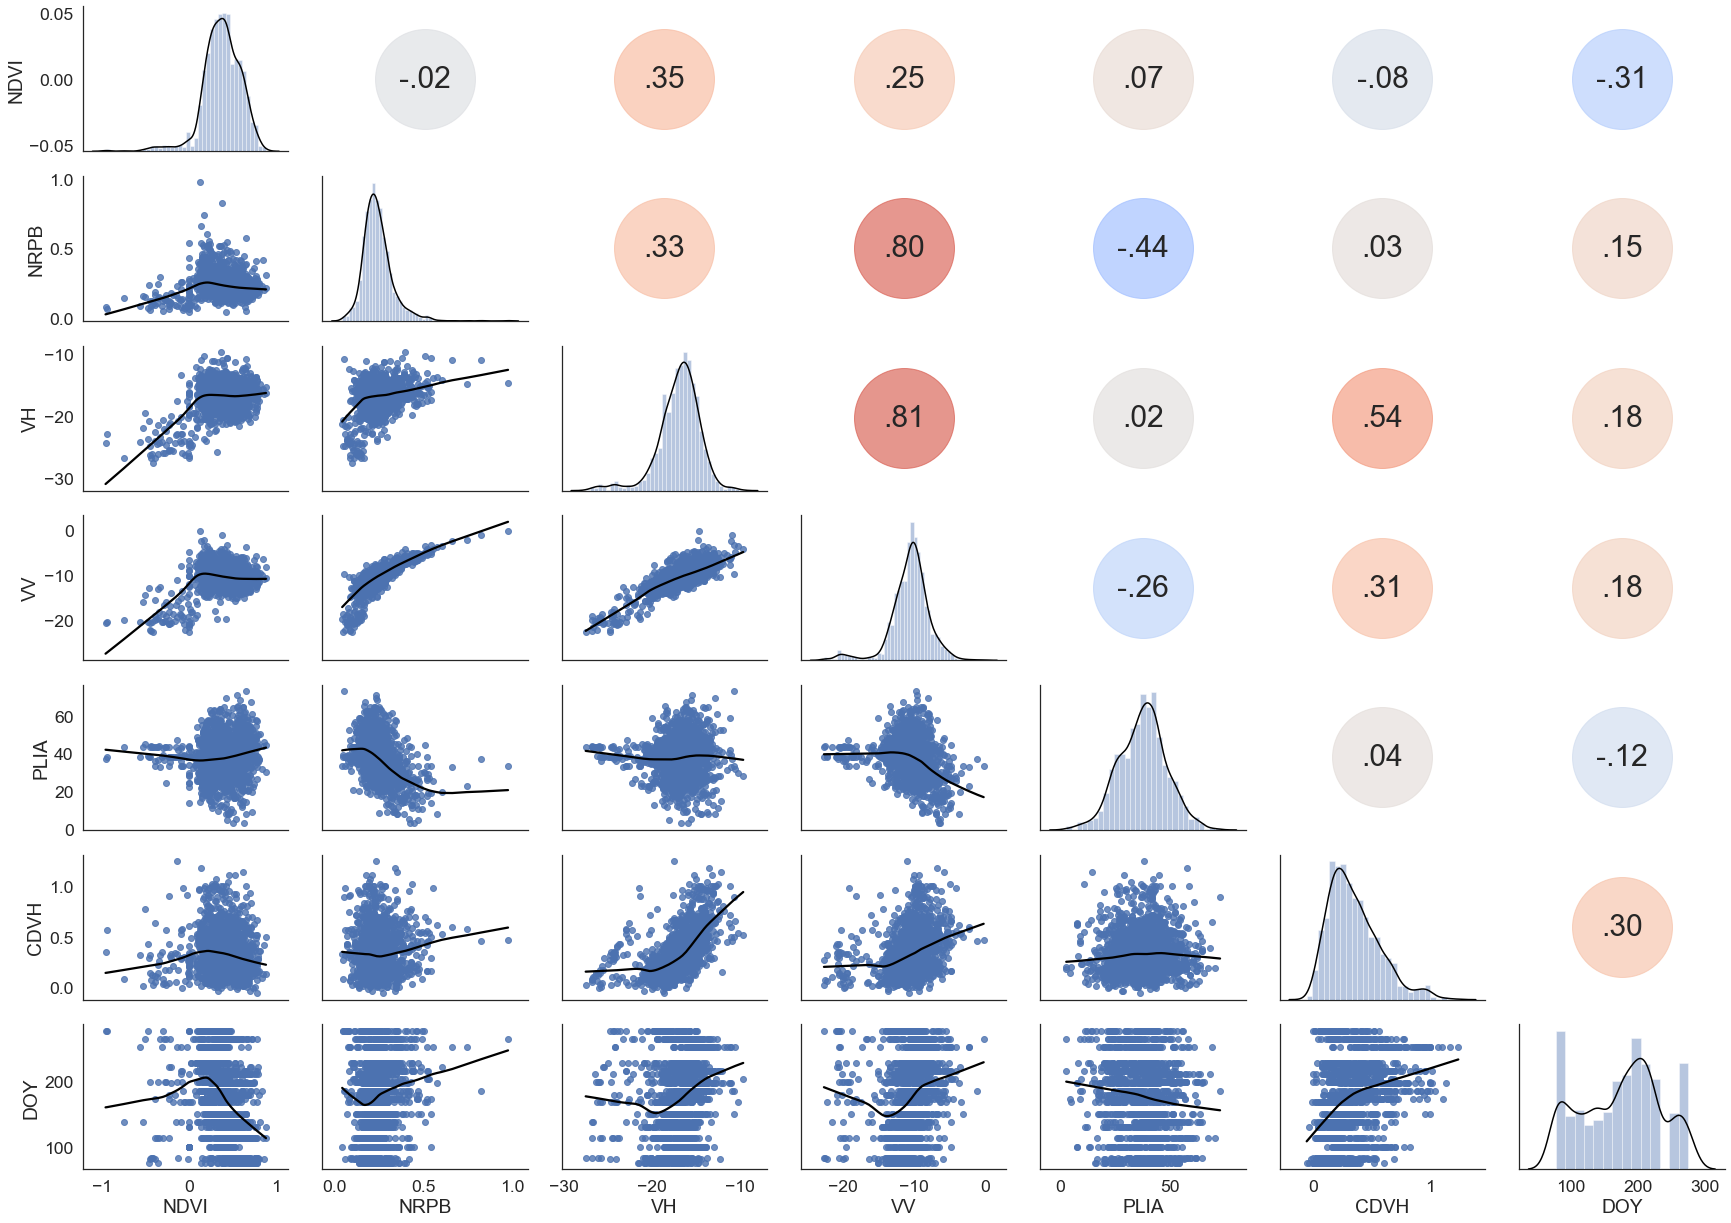

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 42})
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = 30
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(pd.DataFrame(np.c_[y_NDVI_nan_stack, x_NRPB_nan_stack], columns=columns).iloc[:1500, :], aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
#plt.savefig("./Performance/Correlation matrix/"+"_".join([approach, method, ("_".join(get_col_drop(drop)))])+".png")

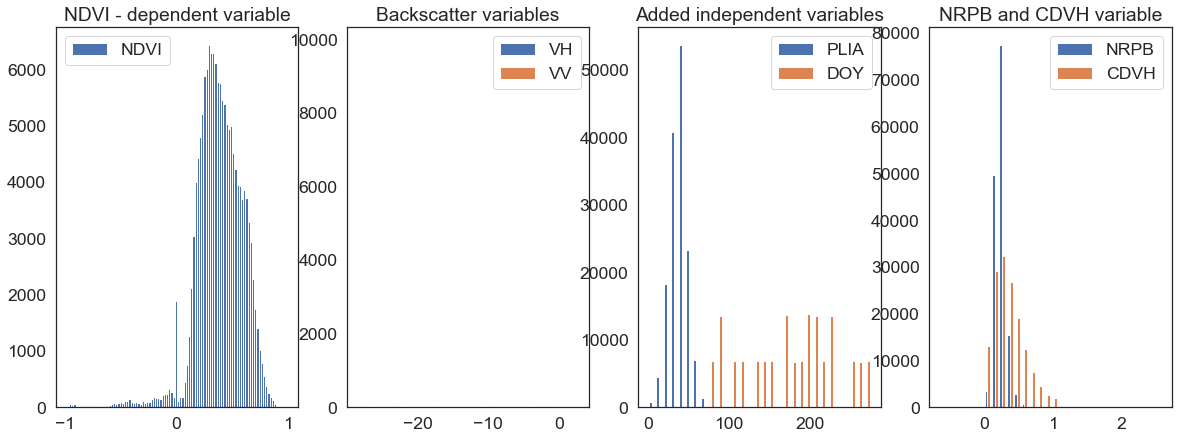

In [28]:
fig, (ax11, ax12, ax13, ax14) = plt.subplots(1, 4, figsize=(20,7))

ax11.hist(y_NDVI_nan_stack, bins=100)
ax11.set_title("NDVI - dependent variable")
ax11.legend(["NDVI"])
ax12.hist(x_NRPB_nan_stack[:, 1:3], bins=100)
ax12.set_title("Backscatter variables")
ax12.legend(["VH", "VV"])
ax13.hist(np.c_[x_NRPB_nan_stack[:, 3], x_NRPB_nan_stack[:, 5]], bins=30)
ax13.set_title("Added independent variables")
ax13.legend(["PLIA", "DOY"])
ax14.hist(np.c_[x_NRPB_nan_stack[:, 0], x_NRPB_nan_stack[:, 4]], bins=30)
ax14.set_title("NRPB and CDVH variable")
ax14.legend(["NRPB", "CDVH"])
#plt.savefig("./Illustration/"+approach+"_"+model+"_"+method+"_"+("_".join(get_col_drop(drop))))
plt.show()

In [18]:
print("Approach:\t", approach, "\nmethod:\t\t", method, "\nmodel:\t\t", model, "\ndrop:\t\t", ", ".join(get_col_drop(drop)))

Approach:	 A2 
method:		 SDS 
model:		 RF 
drop:		 LIA


In [39]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 1600, num = 7)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 90, num = 9)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
display(random_grid)

{'n_estimators': [400, 600, 800, 1000, 1200, 1400, 1600],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None],
 'min_samples_split': [2, 5],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

<font size="5" color="#8b1900"  face="verdana">5.5 Train new sklearn model</font>

In [2]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=3, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(x_NRPB_nan_stack, y_NDVI_nan_stack.ravel())

In [ ]:
new_params = rf_random.best_params_ 
new_params

In [19]:
joblib.dump(rf_random, "./Models/"+approach+"/"+model+"_"+method+"_"+("_".join(get_col_drop(drop)))+".joblib")

['./Models/A2/RF_SCDS_LIA_VH.joblib']

<font size="5" color="#8b1900"  face="verdana">5.6 Predict NDVI from f(NRPB, VH, VV) and save as tif file</font>

In [51]:
rf_random = joblib.load('./Models/A1/RF_SCDS.joblib')

C:\Users\aleks\anaconda3\envs\gpu\lib\site-packages\sklearn\base.py:333: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\aleks\anaconda3\envs\gpu\lib\site-packages\sklearn\base.py:333: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\aleks\anaconda3\envs\gpu\lib\site-packages\sklearn\base.py:333: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.23.2 when using version 1.0.1. This might l

<font size="5" color="#8b1900"  face="verdana">5.6.1 Permutation importance</font>

In [ ]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf_random.best_estimator_, x_valid_NRPB_nan_stack, y_valid_NDVI_nan_stack)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(pd.DataFrame(np.empty((1, 6)), columns=["NRPB", "VH", "VV", "LIA", "PLIA", "CDVH", "DOY"]).columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

IndexError: index 6 is out of bounds for axis 0 with size 6

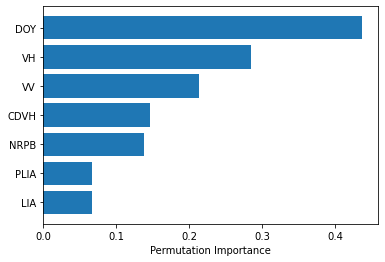

In [ ]:
plt.barh(pd.DataFrame(np.empty((1, 7)), columns=["NRPB", "VH", "VV", "LIA", "PLIA", "CDVH", "DOY"]).columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig('Permutation_importance')

In [56]:
import sklearn.metrics as metrics

def metric_score(y_true, y_pred):
    r2 = metrics.r2_score(y_true, y_pred)
    rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)
    mse = metrics.mean_squared_error(y_true, y_pred, squared=True)
    evar = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    
    
    print("\nR2 score:\t\t\t", r2,
          "\nExplained variance score:\t", evar,
          "\nMean absolute error: \t\t", mae,
          "\nMean squared error: \t\t", mse,
          "\nRoot mean squared error: \t", rmse)
    display([r2, evar, mae, mse, rmse])

pred_valid_NDVI_nc = rf_random.predict(x_valid_NRPB_nan_stack)
metric_score(y_valid_NDVI_nan_stack, pred_valid_NDVI_nc)


R2 score:			 0.6739749165534392 
Explained variance score:	 0.674021717069887 
Mean absolute error: 		 0.08501977473971714 
Mean squared error: 		 0.01378934840262342 
Root mean squared error: 	 0.11742805628393677


[0.6739749165534392,
 0.674021717069887,
 0.08501977473971714,
 0.01378934840262342,
 0.11742805628393677]

In [57]:
print("Approach:\t", approach, "\nmethod:\t\t", method, "\nmodel:\t\t", model, "\ndrop:\t\t", ", ".join(get_col_drop(drop)))

Approach:	 A1 
method:		 SDS 
model:		 RF 
drop:		 


In [64]:
def set_img_change_detection(full_img, full_min, full_max):
    cd_vh = ((full_img[:, 1]-full_min[:, 1])/(full_max[:, 1]-full_min[:, 1]))
    return np.c_[full_img, cd_vh]

In [65]:
img = src.read()

In [29]:
# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
# You may need to reduce image size if your kernel crashes, as this step takes a lot of memory
reshaped_img = reshape_as_image(img)
# Reshape to 2D array
band_num_NRPB = [bands.index(l) for l in bands if "NRPB" in l]
band_num_min = [bands.index(l) for l in bands if "S145" in l][0]
band_num_max = [bands.index(l) for l in bands if "S146" in l][0]
print(reshaped_img[:, :, 0])
full_min = reshaped_img[:, :, band_num_min: band_num_min + 2].reshape(-1, 2)
full_max = reshaped_img[:, :, band_num_max: band_num_max + 2].reshape(-1, 2)
print(reshaped_img[:, :, 0])
for i in range(1, 2):
    band_num_NRPB_sub = band_num_NRPB[i]  # start index for Sentinel-1 bands
    
    class_input_S1 = reshaped_img[:, :, band_num_NRPB_sub: band_num_NRPB_sub + 5].reshape(-1, 5)
    print(reshaped_img[:, :, 0])

    x_doy = days_of_year[int(re.search('_S(.*)', bands[band_num_NRPB_sub]).group(1))]
    class_input_S1 = np.c_[log_training_data(set_img_change_detection(class_input_S1, full_min, full_max)), np.full((class_input_S1.shape[0],1),x_doy)]
    print(class_input_S1.shape) 
    class_input_S1 = np.delete(class_input_S1, delete_col, 1)
    class_input_S1 = np.float32(class_input_S1)
    class_input_S1 = np.where(np.isnan(class_input_S1), -999, class_input_S1)
    print(class_input_S1.shape) 
    
    class_RF_S1 = rf_random.predict(class_input_S1)
    print("Finished prediction")
    
    class_RF_S1 = class_RF_S1.reshape(reshaped_img[:, :, 0].shape)
    print("Finished reshaping")
    
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1, tiled=False)
    tif = './Predicted/'+approach+'/'+method+'/'+model+'_'+approach+'_'+method+'_'+('_'.join(get_col_drop(drop)))+'_'+bands[band_num_NRPB_sub]+'.tif'
    print("Saved to: "+ tif)
    rasterio.open(tif, 'w', **profile).write(class_RF_S1.astype(rasterio.float32), 1)

C:\Users\aleks\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  


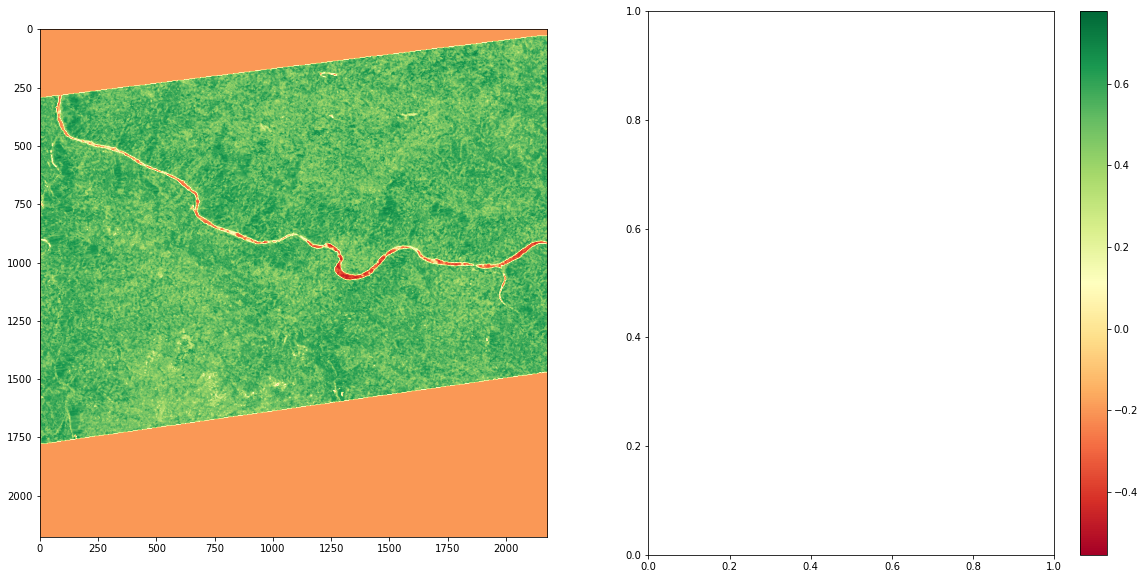

In [69]:
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
im1 = ax1.imshow(class_RF_S1, cmap="RdYlGn")
im2 = ax2.imshow(img[0], cmap="RdYlGn")
fig.colorbar(im1)

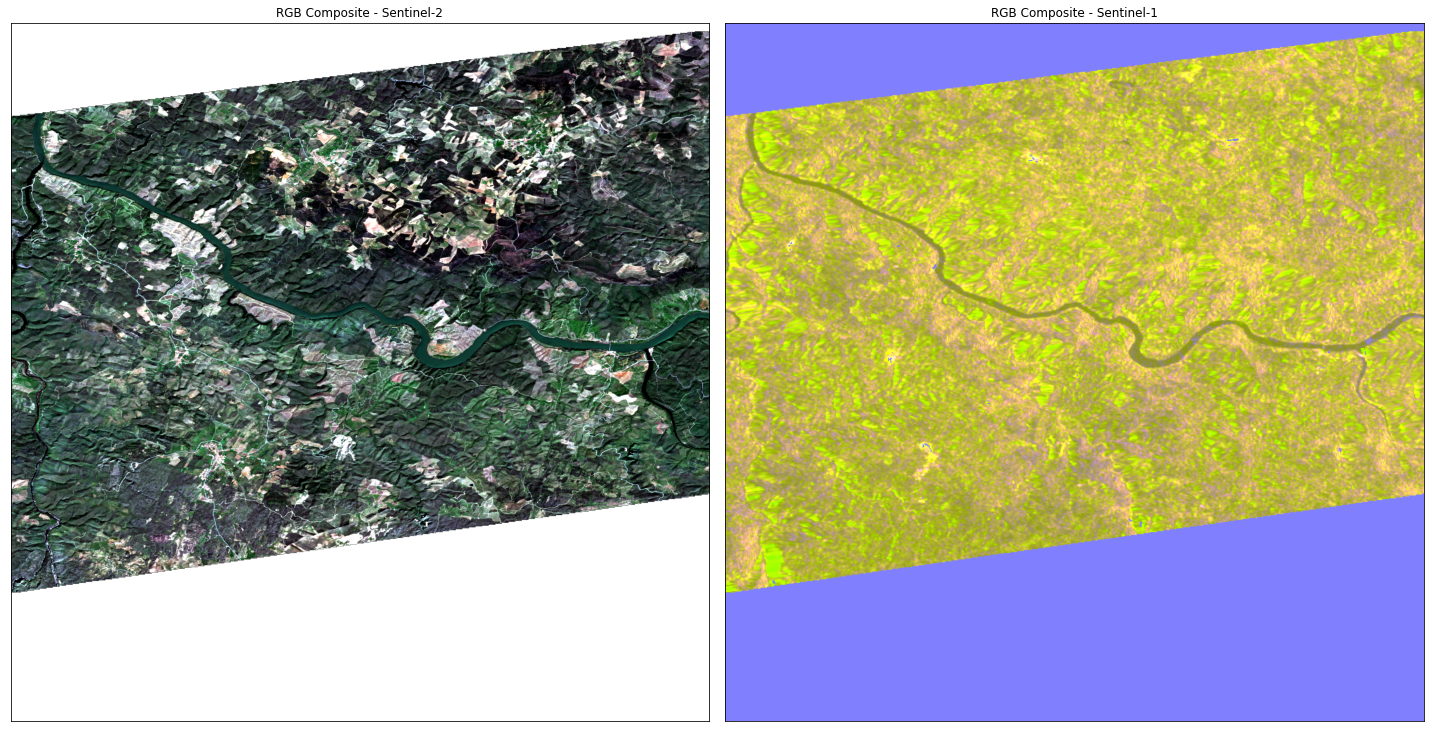

In [7]:
stack = src.read()
# Create a figure and plot the RGB composites of first Sentinel-2 image (True color) and first Sentinel-1 image (Dual Pol Ratio VV+VH)
# The band numbers must be changed accordingly to your input dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10)) # matplotlib.pyplot.subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)
ax1 = ep.plot_rgb(arr = stack, rgb = (5, 4, 3), ax = ax1, stretch=True, title="RGB Composite - Sentinel-2")
ax2 = ep.plot_rgb(arr = stack, rgb = (461, 462, 460), ax = ax2, stretch=True, title="RGB Composite - Sentinel-1")
plt.tight_layout()

<font size="5" color="#8b1900"  face="verdana">Pixel classification</font>

In [27]:
# create a color dictionary with specific colors assigned to specific crop type. 
colors = dict((
    (0, (0,153,255,255)),    # Water
    (1, (255,236,179,255)),  # Non irrigated arable land
    (2, (153,0,153,255))    # Vineyards
#     (3, (255,153,51,255)),   # Winter Crop - Maize
#     (4, (255,255,0,255)),    # Peanut
#     (5, (204,153,255,255)),  # Rangeland/Pasture
#     (6, (178,255,102,255)),  # Natural woody vegetation
#     (7, (0,0,0,255))         # Masked
))

# Convert 0 - 255 values to float in range 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v

# Create matplotlib colormap from a list of colors and call it Classification   
index_colors = [colors[key] if key in colors else (1, 1, 1, 0) for key in range(0, 8)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', 8)

In [ ]:
# Path to Training and Validation label pixel csv file
training_points = './Labels/Pixel_labels.csv'
# validation_points = './Shapefiles/Validation_points200.shp'

class_names = ['Masked', 'Vineyards', 'Fruit trees and berry plantations'] 

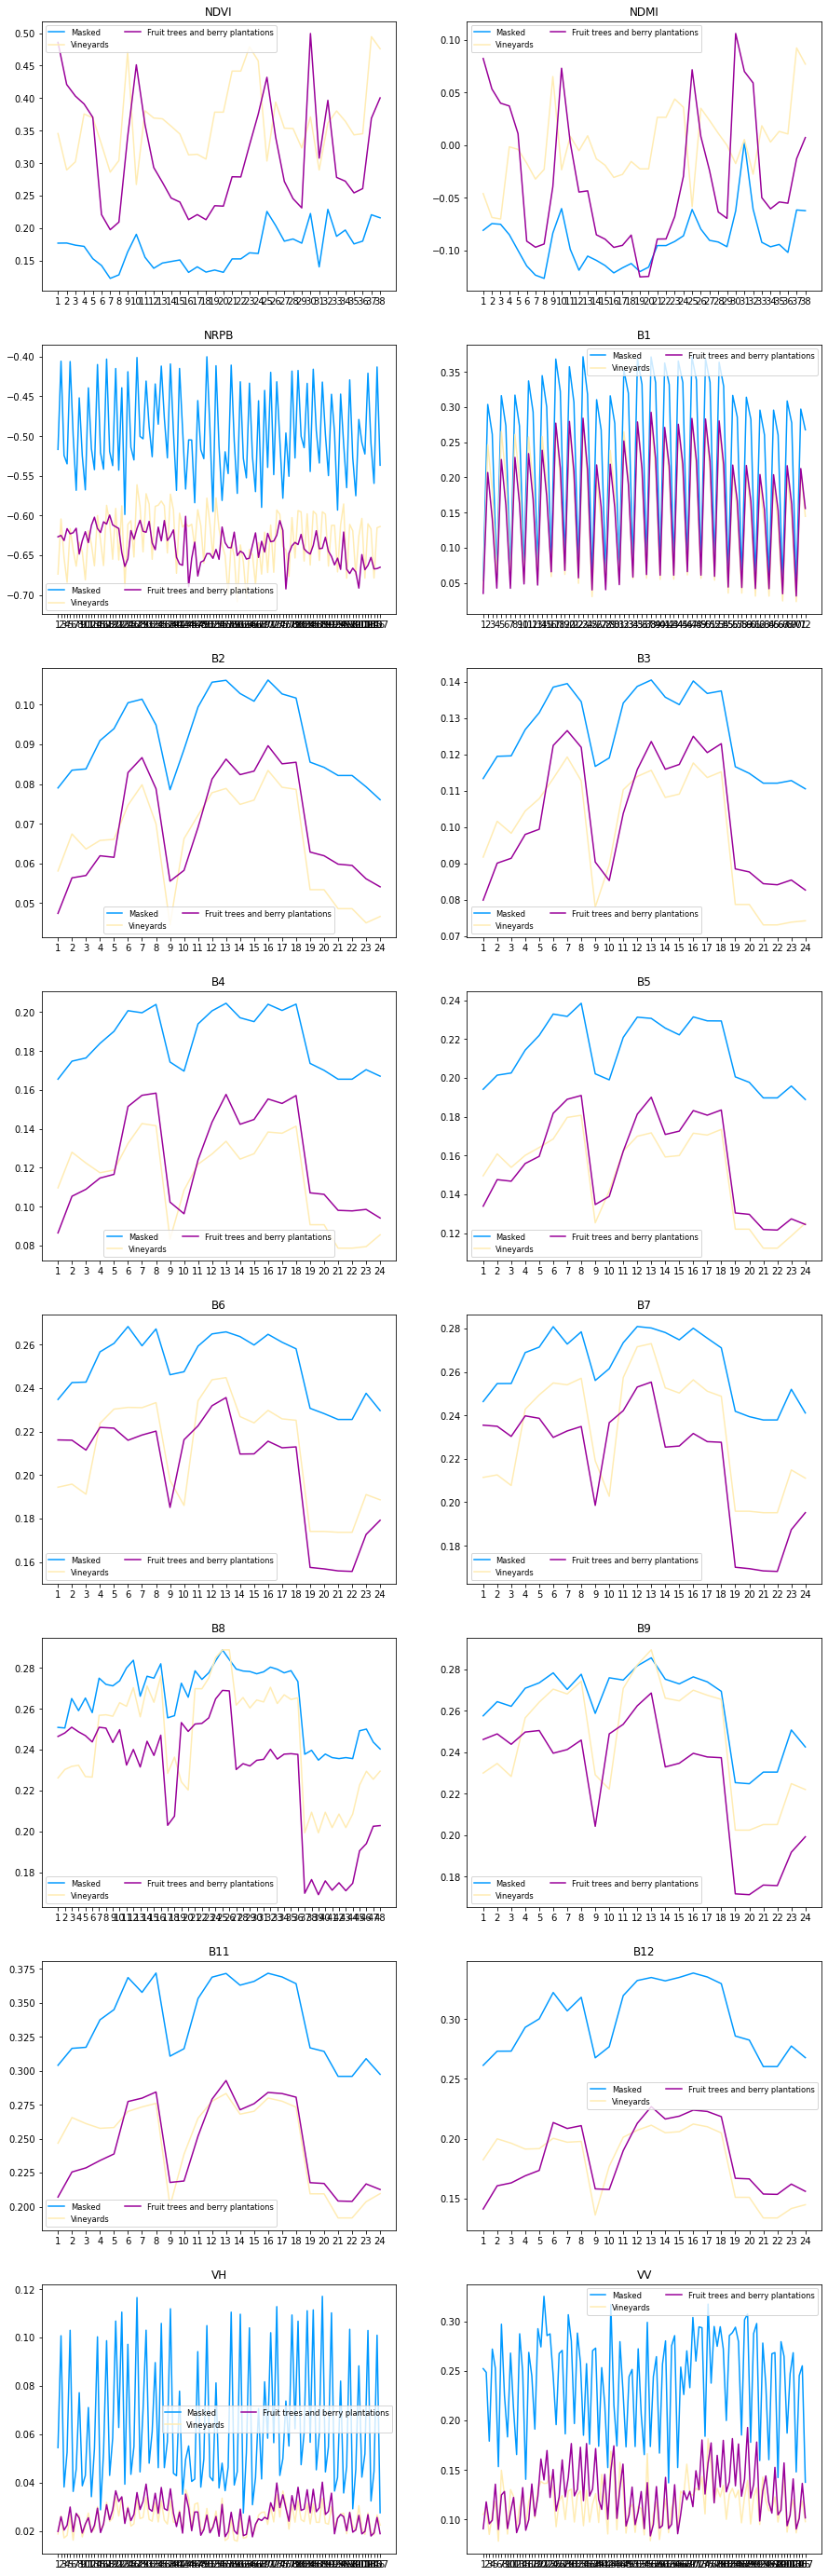

In [11]:
# Plot Class profiles over our dataset (September 2018 - June 2019)
prof = train_pts.groupby(['GRIDCODE']).mean()  #calculate average value for each class in each band
fig = plt.figure(figsize = (15,50)) 
band_n = ['NDVI', 'NDMI', 'NRPB', 'B1','B2','B3','B4','B5', 'B6', 'B7','B8','B9','B11','B12','VH','VV'] # bands we included in the analysis for each name we have multiple dates included
n = 1  # counter
for ba in band_n:  # Iterate over band names
    ax = fig.add_subplot(8,2,n) 
    ax.title.set_text(ba)
    band_val = prof[prof.columns[prof.columns.to_series().str.contains(ba)]]  # Select all columns in the dataframe containing a band name e.g. B2
    for index, row in band_val.iterrows():  # Plot line for each class in the selected band
        color = cmap(index-1)  
        ax.plot(row, color=color) 
    ax.set_xticklabels([str(x) for x in range(1, len(row)+1)])  # Replace column names with numbers
    ax.legend(loc="best", fontsize='small', ncol=2, labels=class_names)
    n = n+1